# **Introduction**

This notebook demostrates how to use an object detector and an image classifier to detect dogs in an image and then classify the breed of the dogs if dogs are detected.  
Tensorflow Lite is used in this notebook. Detection model comes from [Coral](https://coral.ai/models/object-detection/).  
Dog breed classifier comes from https://www.kaggle.com/code/jasonhcwong/dog-breed-classification-using-efficientnet/

# Import required libraries

In [1]:
import os
import io
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import cv2
from PIL import Image

# Define the lables and index for the dog breeds

In [2]:
class_idx_2_name = {
    1: 'Chihuahua',
    2: 'Japanese_spaniel',
    3: 'Maltese_dog',
    4: 'Pekinese',
    5: 'Shih-Tzu',
    6: 'Blenheim_spaniel',
    7: 'papillon',
    8: 'toy_terrier',
    9: 'Rhodesian_ridgeback',
    10: 'Afghan_hound',
    11: 'basset',
    12: 'beagle',
    13: 'bloodhound',
    14: 'bluetick',
    15: 'black-and-tan_coonhound',
    16: 'Walker_hound',
    17: 'English_foxhound',
    18: 'redbone',
    19: 'borzoi',
    20: 'Irish_wolfhound',
    21: 'Italian_greyhound',
    22: 'whippet',
    23: 'Ibizan_hound',
    24: 'Norwegian_elkhound',
    25: 'otterhound',
    26: 'Saluki',
    27: 'Scottish_deerhound',
    28: 'Weimaraner',
    29: 'Staffordshire_bullterrier',
    30: 'American_Staffordshire_terrier',
    31: 'Bedlington_terrier',
    32: 'Border_terrier',
    33: 'Kerry_blue_terrier',
    34: 'Irish_terrier',
    35: 'Norfolk_terrier',
    36: 'Norwich_terrier',
    37: 'Yorkshire_terrier',
    38: 'wire-haired_fox_terrier',
    39: 'Lakeland_terrier',
    40: 'Sealyham_terrier',
    41: 'Airedale',
    42: 'cairn',
    43: 'Australian_terrier',
    44: 'Dandie_Dinmont',
    45: 'Boston_bull',
    46: 'miniature_schnauzer',
    47: 'giant_schnauzer',
    48: 'standard_schnauzer',
    49: 'Scotch_terrier',
    50: 'Tibetan_terrier',
    51: 'silky_terrier',
    52: 'soft-coated_wheaten_terrier',
    53: 'West_Highland_white_terrier',
    54: 'Lhasa',
    55: 'flat-coated_retriever',
    56: 'curly-coated_retriever',
    57: 'golden_retriever',
    58: 'Labrador_retriever',
    59: 'Chesapeake_Bay_retriever',
    60: 'German_short-haired_pointer',
    61: 'vizsla',
    62: 'English_setter',
    63: 'Irish_setter',
    64: 'Gordon_setter',
    65: 'Brittany_spaniel',
    66: 'clumber',
    67: 'English_springer',
    68: 'Welsh_springer_spaniel',
    69: 'cocker_spaniel',
    70: 'Sussex_spaniel',
    71: 'Irish_water_spaniel',
    72: 'kuvasz',
    73: 'schipperke',
    74: 'groenendael',
    75: 'malinois',
    76: 'briard',
    77: 'kelpie',
    78: 'komondor',
    79: 'Old_English_sheepdog',
    80: 'Shetland_sheepdog',
    81: 'collie',
    82: 'Border_collie',
    83: 'Bouvier_des_Flandres',
    84: 'Rottweiler',
    85: 'German_shepherd',
    86: 'Doberman',
    87: 'miniature_pinscher',
    88: 'Greater_Swiss_Mountain_dog',
    89: 'Bernese_mountain_dog',
    90: 'Appenzeller',
    91: 'EntleBucher',
    92: 'boxer',
    93: 'bull_mastiff',
    94: 'Tibetan_mastiff',
    95: 'French_bulldog',
    96: 'Great_Dane',
    97: 'Saint_Bernard',
    98: 'Eskimo_dog',
    99: 'malamute',
    100: 'Siberian_husky',
    101: 'affenpinscher',
    102: 'basenji',
    103: 'pug',
    104: 'Leonberg',
    105: 'Newfoundland',
    106: 'Great_Pyrenees',
    107: 'Samoyed',
    108: 'Pomeranian',
    109: 'chow',
    110: 'keeshond',
    111: 'Brabancon_griffon',
    112: 'Pembroke',
    113: 'Cardigan',
    114: 'toy_poodle',
    115: 'miniature_poodle',
    116: 'standard_poodle',
    117: 'Mexican_hairless',
    118: 'dingo',
    119: 'dhole',
    120: 'African_hunting_dog'
}

# Run the models and show the result
The input image is first processed by a object detector that detects the dogs in the image. The result of the detection are bounding boxes and detection scores. For every dog being detected with a score higher than the threshold(0.4), a close-up image (the bounding box) of the dog will be cropped and thensubmitted to the dog breed classifier. The result of the dog breed classifier gives the dog breed and the classification score.  
Lastly, the dog detection and classfication result will be overlayed on the input image and display here.

Detection:
	score:0.844
Classification:
	breed: West_Highland_white_terrier(52)
	score: 0.990


Detection:
	score:0.832
Classification:
	breed: golden_retriever(56)
	score: 1.000


Detection:
	score:0.820
Classification:
	breed: English_springer(66)
	score: 0.999


Detection:
	score:0.699
Classification:
	breed: Great_Dane(95)
	score: 0.674


Detection:
	score:0.613
Classification:
	breed: bull_mastiff(92)
	score: 0.892


Detection:
	score:0.480
Classification:
	breed: German_shepherd(84)
	score: 0.982




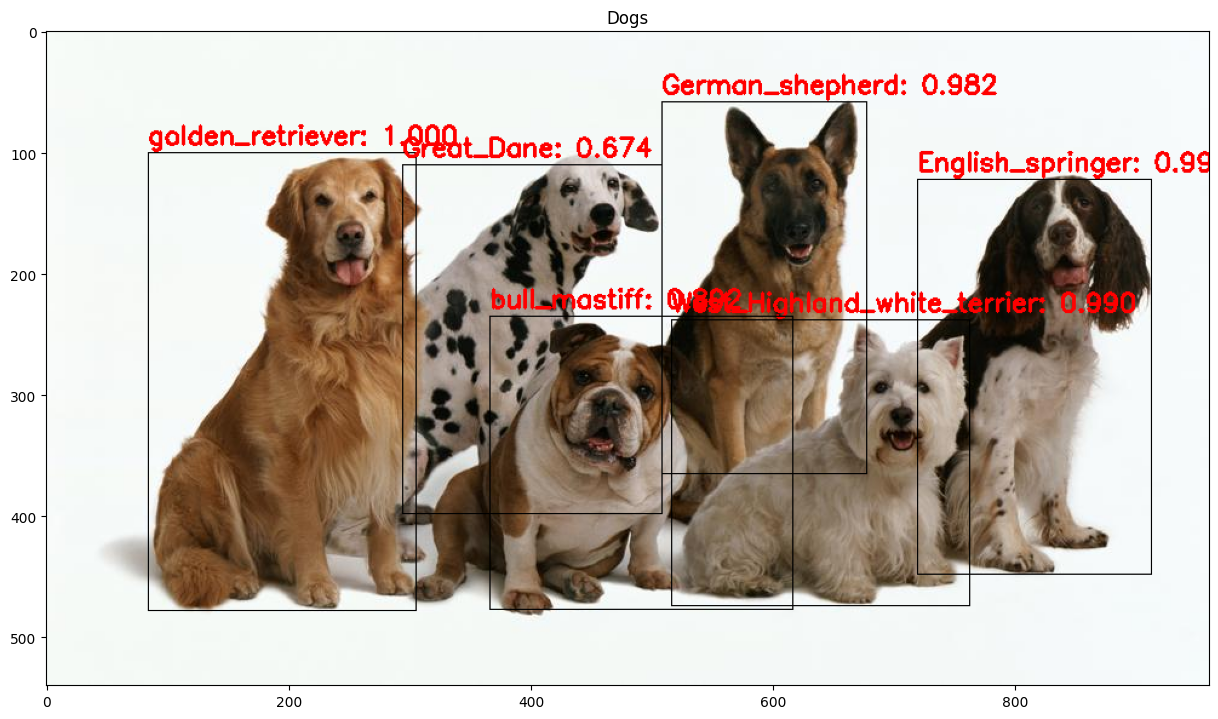

In [7]:
# prepare the model to detect dogs in an image
dog_detector = tf.lite.Interpreter(model_path="efficientdet_lite3x_640_ptq.tflite")
dog_detector.allocate_tensors()
detector_input_details = dog_detector.get_input_details()
detector_output_details = dog_detector.get_output_details()

# prepare the model to classifiy dog breed
dog_classifier = tf.lite.Interpreter(model_path="dog_breed_classifier.tflite")
dog_classifier.allocate_tensors()
classifier_input_details = dog_classifier.get_input_details()
classifier_output_details = dog_classifier.get_output_details()

# read the input image and pre-process the input
frame_bgr = cv2.imread('dogs6.jpg')
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
ori_h, ori_w, _ = frame_rgb.shape
frame_resized = cv2.resize(frame_rgb, (640, 640))
input_data = np.expand_dims(frame_resized, axis=0)

# dog detection model inference
dog_detector.set_tensor(detector_input_details[0]['index'], input_data)
dog_detector.invoke()

# get the result of dog detection
boxes = dog_detector.get_tensor(detector_output_details[0]['index'])[0]
classes = dog_detector.get_tensor(detector_output_details[1]['index'])[0]
scores = dog_detector.get_tensor(detector_output_details[2]['index'])[0]

frame = frame_rgb
for i in range(len(scores)):
    # process the detection boxes with class == dog and score > 0.4
    if (classes[i] == 17.0 and scores[i] > 0.4):
        # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
        ymin = int(max(1, (boxes[i][0] * ori_h)))
        xmin = int(max(1, (boxes[i][1] * ori_w)))
        ymax = int(min(ori_h, (boxes[i][2] * ori_h)))
        xmax = int(min(ori_w, (boxes[i][3] * ori_w)))

        # crop the close-up of a dog and pre-process for dog classification
        crop_img = frame[ymin:ymax, xmin:xmax]
        dog_frame = cv2.resize(crop_img, (224, 224))
        dog_frame = dog_frame.astype(np.float32)
        dog_data = np.expand_dims(dog_frame, axis=0)
        # dog classification inference
        dog_classifier.set_tensor(classifier_input_details[0]['index'], dog_data)
        dog_classifier.invoke()
        dog_scores = dog_classifier.get_tensor(classifier_output_details[0]['index'])[0]

        index = np.argmax(dog_scores)
        breed = class_idx_2_name[index+1]
        
        # process the classification of dog breed if score > 0.6
        if dog_scores[index] > 0.6:
            # Draw bbox
            cv2.rectangle(frame, (xmin, ymin),(xmax, ymax), (0, 0, 0), 1)

            # Print label
            label = '%s: %.3f' % (breed, dog_scores[index])
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            
            # Make sure not to draw label too close to top of window
            label_ymin = max(ymin, labelSize[1] + 10)
            cv2.putText(frame, label, (xmin, label_ymin-7),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            print("Detection:\n\tscore:{:.3f}\nClassification:\n\tbreed: {}({})\n\tscore: {:.3f}\n\n".format(scores[i], breed, index, dog_scores[index]))

plt.figure(figsize=(15,15))
plt.imshow(frame)
plt.title('Dogs')
plt.show()

#cv2.imwrite('output.jpg', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))